In [1]:
import pm4py
from collections import Counter

from sklearn.cluster import DBSCAN, KMeans

log_path = "logs/running-example.jsonocel"
ocel = pm4py.read_ocel_json(log_path)

/Users/wojciechzyla/Desktop/AGH/semestr_8/MB/projekt-mb/env_mb/lib/python3.8/site-packages/pm4py/util/dt_parsing/parser.py:76: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(


In [2]:
object_types = list(set(ocel.objects["ocel:type"]))
object_type_to_id = {k:i for i, k in enumerate(object_types)}
object_type_to_id

{'products': 0, 'orders': 1, 'items': 2, 'customers': 3, 'packages': 4}

In [3]:
ocel.objects[ocel.objects["ocel:type"]=="customers"]

,ocel:oid,ocel:type,cost,producer,age,bankaccount
20,Marco Pegoraro,customers,NaN,NaN,50.0,91248.0
21,Gyunam Park,customers,NaN,NaN,55.0,27275.0
22,Majid Rafiei,customers,NaN,NaN,46.0,74370.0
23,Junxiong Gao,customers,NaN,NaN,52.0,96270.0
24,Seran Uysal,customers,NaN,NaN,40.0,69940.0
25,Christina Rensinghof,customers,NaN,NaN,41.0,17020.0
26,Wil van der Aalst,customers,NaN,NaN,34.0,48846.0
27,Christine Dobbert,customers,NaN,NaN,43.0,59702.0
28,Luis Santos,customers,NaN,NaN,48.0,37644.0
29,Kefang Ding,customers,NaN,NaN,38.0,76896.0


In [4]:
activity_to_numeric = {k:i for i, k in enumerate(list(set(ocel.events["ocel:activity"])))}
activity_to_numeric

{'create package': 0,
 'confirm order': 1,
 'item out of stock': 2,
 'failed delivery': 3,
 'payment reminder': 4,
 'pick item': 5,
 'reorder item': 6,
 'place order': 7,
 'send package': 8,
 'pay order': 9,
 'package delivered': 10}

In [5]:
import numpy as np
x = []
event_ids = list(ocel.events["ocel:eid"])
for eid in event_ids:
    eid_num = float(eid)
    if eid_num%1000==0:
        print(eid_num)
    counted = Counter(ocel.relations[ocel.relations["ocel:eid"]==eid]["ocel:type"])
    event_vec = np.zeros(len(object_type_to_id))
    for k in counted.keys():
        vec_id = object_type_to_id[k]
        event_vec[vec_id] += counted[k]
    x.append(event_vec)
x = np.array(x)

1000.0
2000.0
3000.0
4000.0
5000.0
6000.0
7000.0
8000.0
9000.0
10000.0
11000.0
12000.0
13000.0
14000.0
15000.0
16000.0
17000.0
18000.0
19000.0
20000.0
21000.0
22000.0


In [6]:
from clustering_api import ClusteringOCEL

dbscan1 = DBSCAN(eps=0.2, min_samples=5)
dbscan2 = DBSCAN(eps=0.5, min_samples=5)
kmeans = KMeans(n_clusters=6, init="k-means++")
ocel_dbscan1 = ClusteringOCEL(model=dbscan1, ocel=ocel, dataset_from_ocel=x)
ocel_dbscan2 = ClusteringOCEL(model=dbscan2, ocel=ocel, dataset_from_ocel=x)
ocel_kmeans = ClusteringOCEL(model=kmeans, ocel=ocel, dataset_from_ocel=x)

In [7]:
ocel_dbscan1.fit(normalize=True)
print(ocel_dbscan1.unique_labels())

[0 1 2 3]


In [8]:
ocel_kmeans.fit(normalize=True)
print(ocel_kmeans.unique_labels())

[0 1 2 3 4 5]


/Users/wojciechzyla/Desktop/AGH/semestr_8/MB/projekt-mb/env_mb/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [9]:
from collections import defaultdict
clusters = defaultdict(list)
labels = ocel_dbscan1.model.labels_
for i in range(labels.size):
    clusters[labels[i]].append(ocel_dbscan1.ocel.events.iloc[i]["ocel:eid"])

In [10]:
for k, v in clusters.items():
    print(k, v[:10])

0 ['1.0', '2.0', '4.0', '6.0', '7.0', '9.0', '11.0', '14.0', '17.0', '18.0']
1 ['3.0', '5.0', '8.0', '10.0', '12.0', '13.0', '15.0', '16.0', '21.0', '22.0']
2 ['1060.0', '1095.0', '1155.0', '1467.0', '1470.0', '1488.0', '1557.0', '1612.0', '1636.0', '1656.0']
3 ['7083.0', '7098.0', '7181.0', '8723.0', '8754.0', '8789.0', '8875.0', '8912.0', '12669.0', '12700.0']


In [11]:
ocel.relations[ocel.relations["ocel:eid"]=="8.0"]

,ocel:eid,ocel:activity,ocel:timestamp,ocel:oid,ocel:type,ocel:qualifier
58,8.0,item out of stock,2019-05-20 13:54:37,880004,items,None
59,8.0,item out of stock,2019-05-20 13:54:37,Marco Pegoraro,customers,None
60,8.0,item out of stock,2019-05-20 13:54:37,Echo Studio,products,None
61,8.0,item out of stock,2019-05-20 13:54:37,990001,orders,None


In [12]:
for k, v in clusters.items():
    print(f"cluster {k}, number of events {len(v)}")

cluster 0, number of events 10256
cluster 1, number of events 11879
cluster 2, number of events 214
cluster 3, number of events 18


In [23]:
plot_data = {}
object_types = list(set(ocel.objects["ocel:type"]))
for k, v in clusters.items():
    plot_data[k] = {}
    for ot in object_types:
        plot_data[k][ot] = []
    for eid in v:
        counted = Counter(ocel.relations[ocel.relations["ocel:eid"]==eid]["ocel:type"])
        for c_key in counted.keys():
            plot_data[k][c_key].append(counted[c_key])

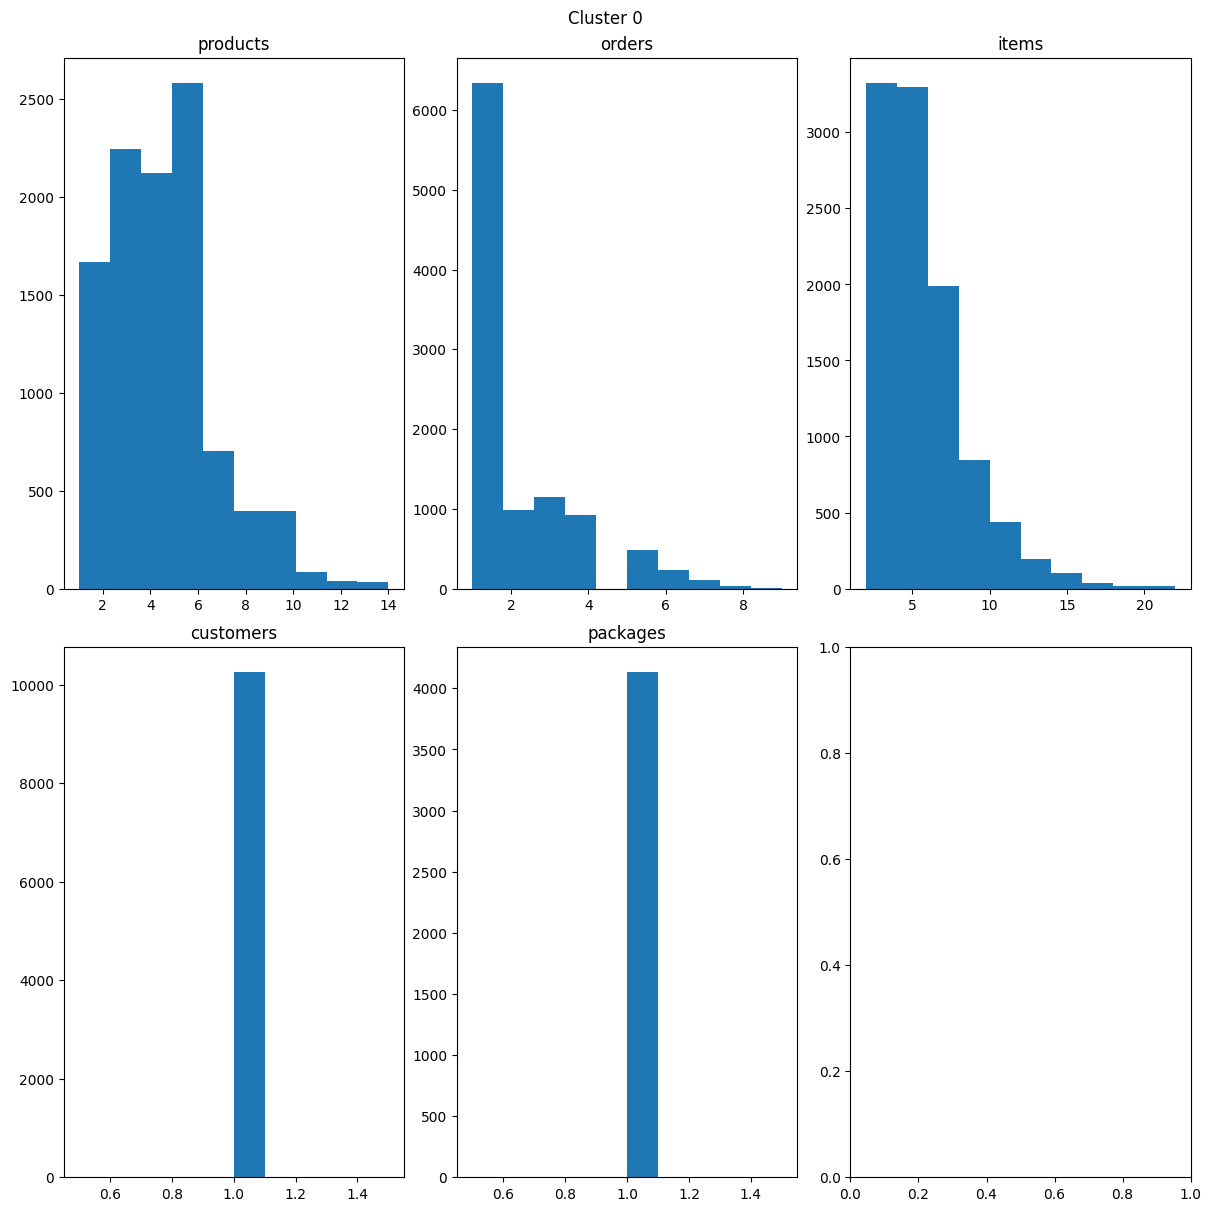

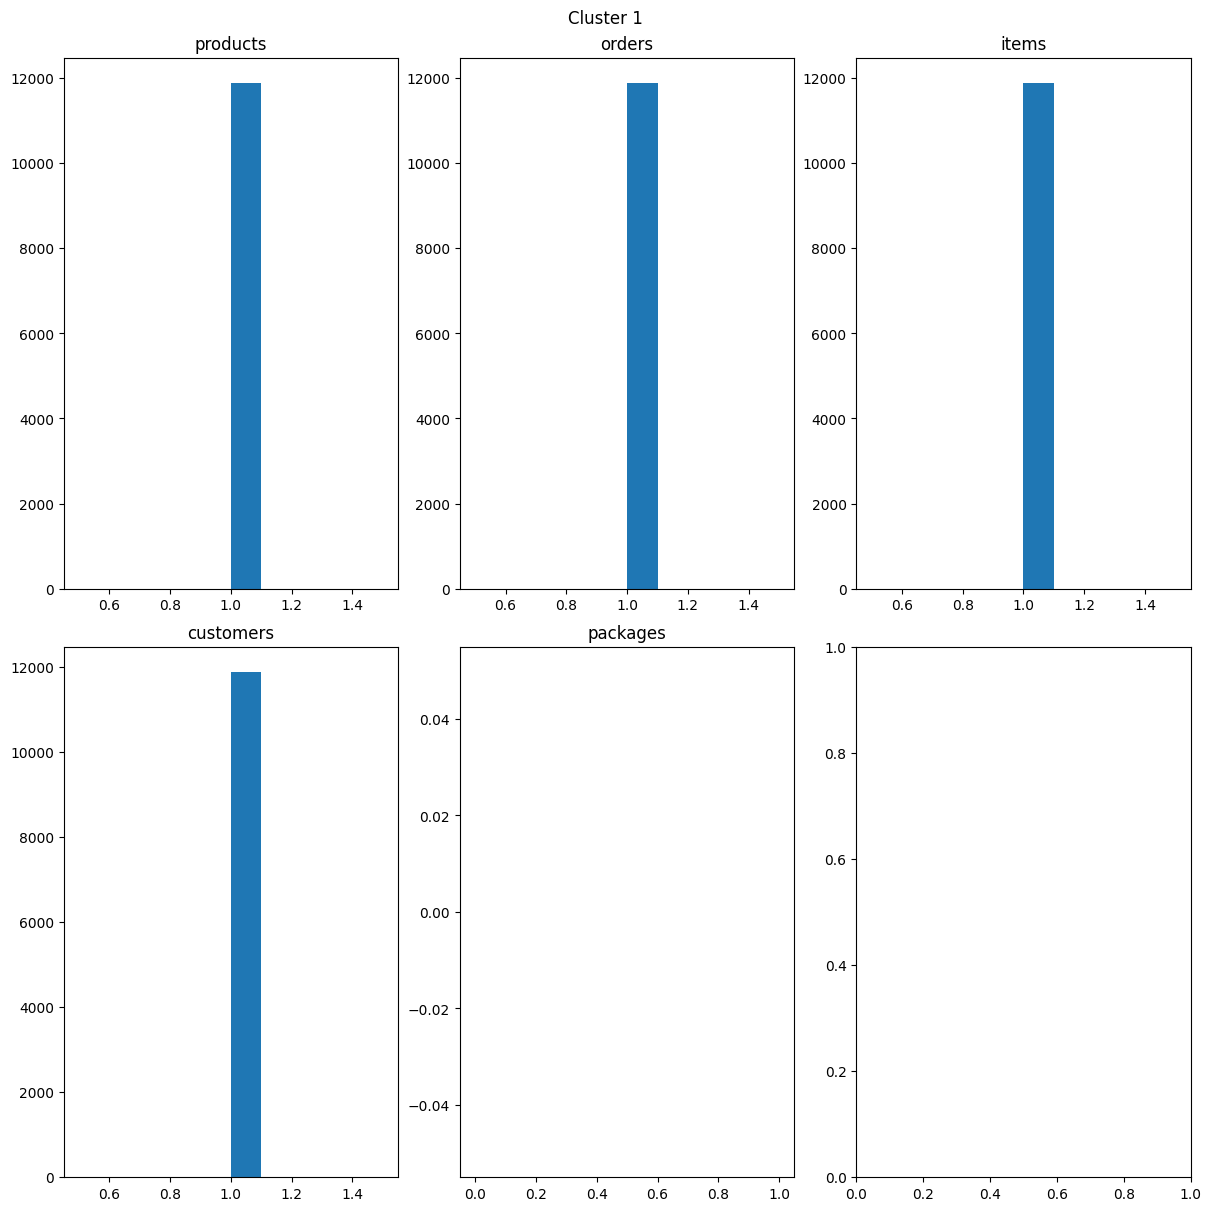

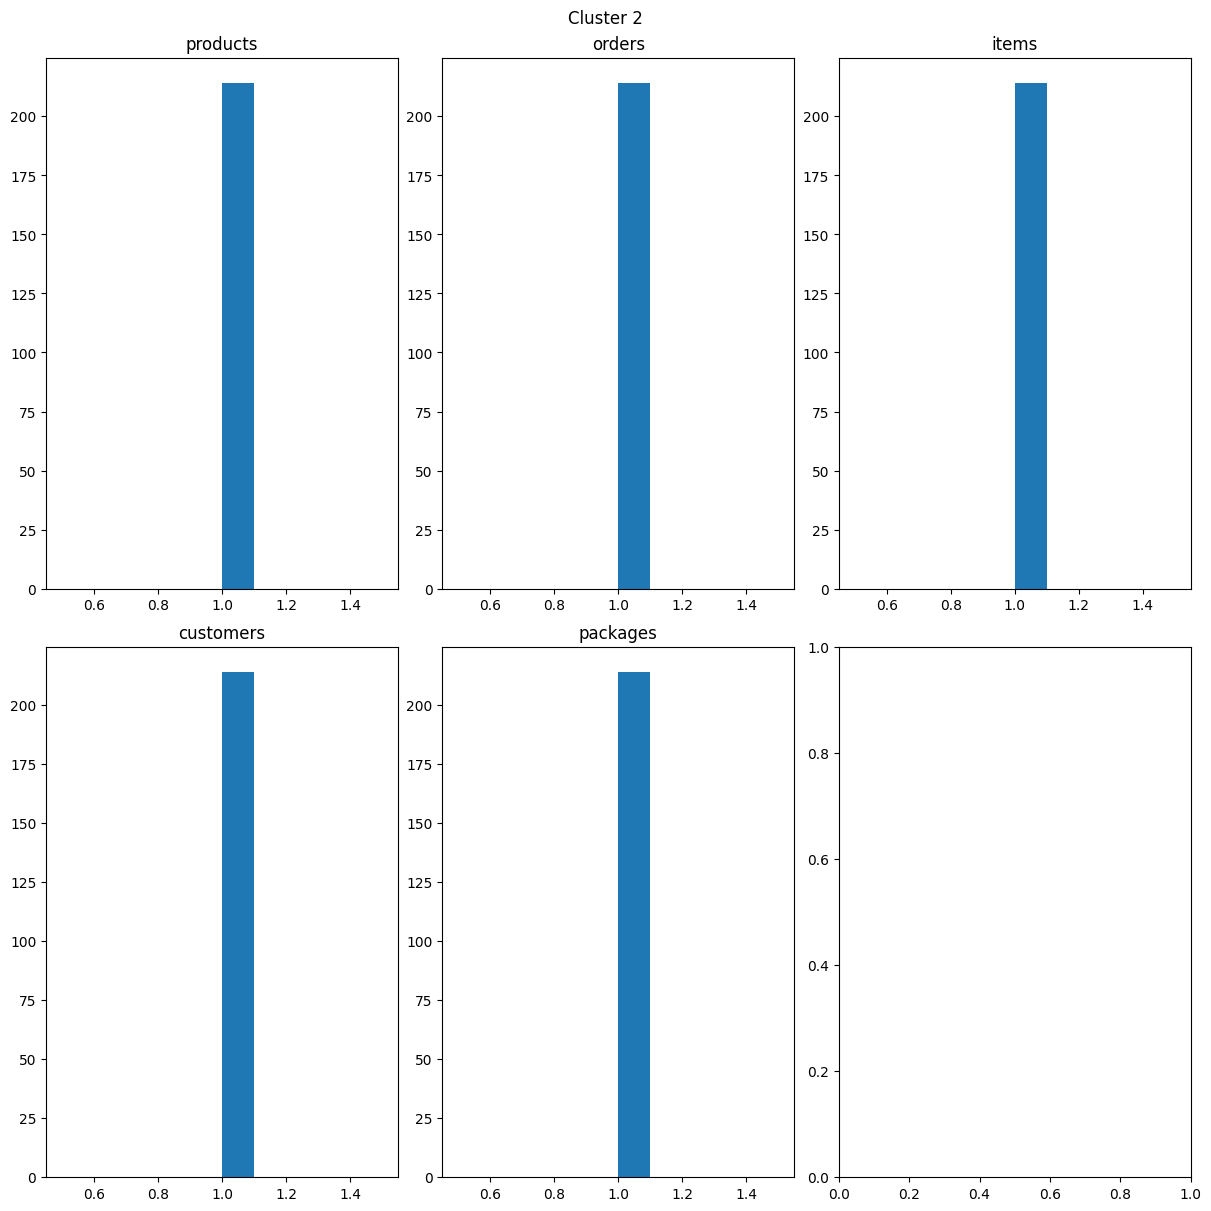

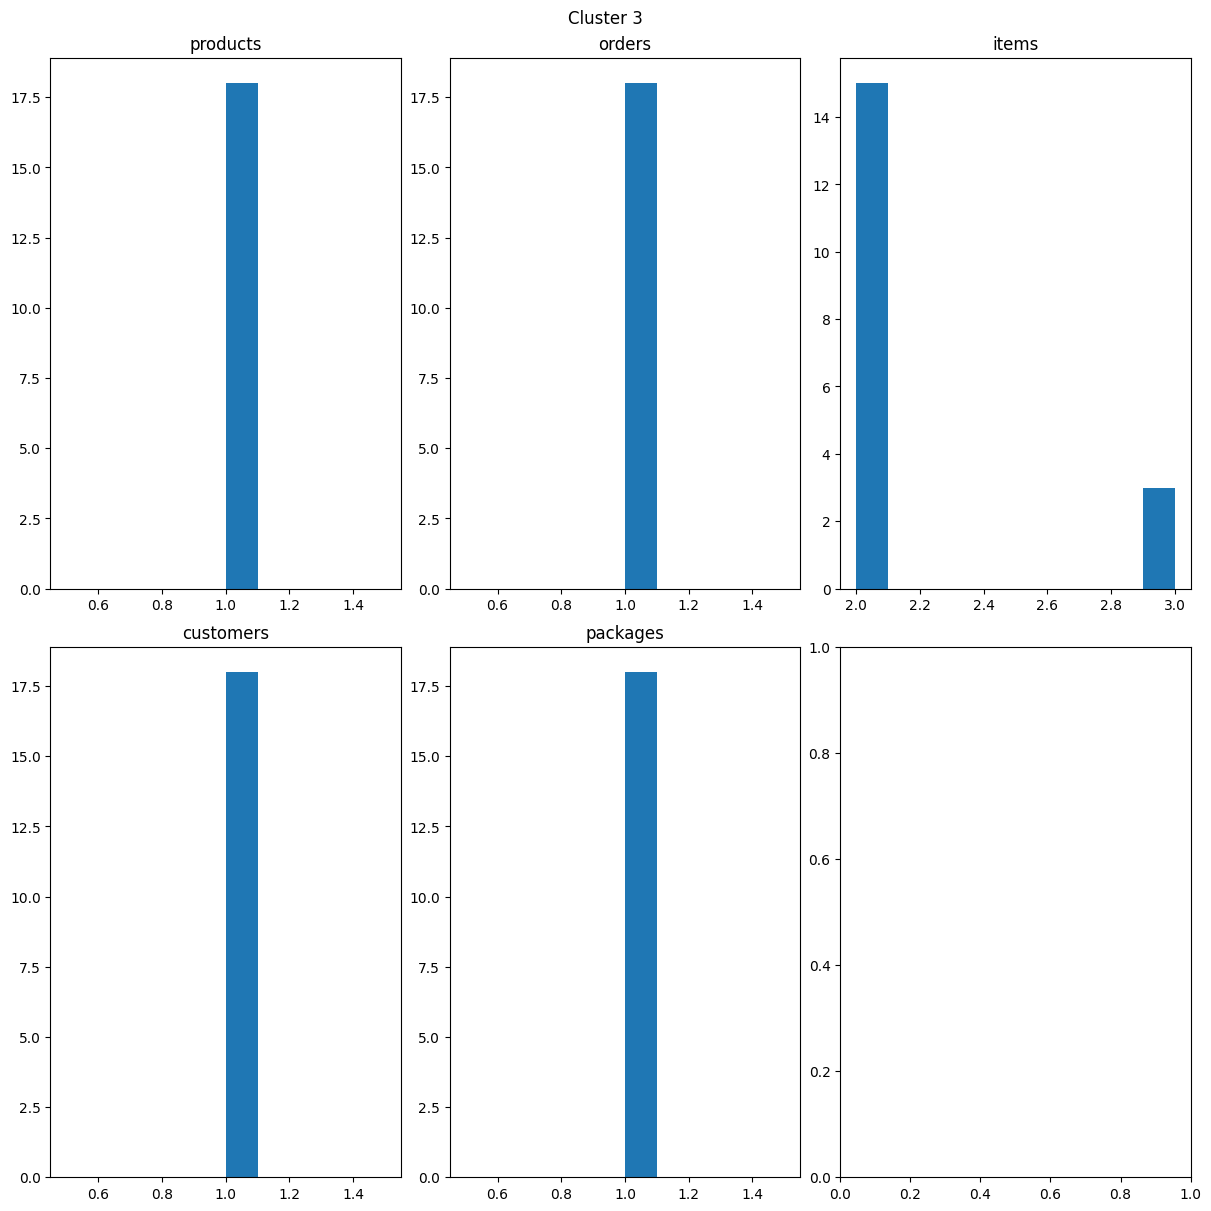

In [24]:
import matplotlib.pyplot as plt

for k in plot_data.keys():
    fig, ax = plt.subplots(2,3, constrained_layout=True, figsize=(12,12))

    ax[0,0].hist(plot_data[k]['products'])
    ax[0,0].set_title('products')

    ax[0,1].hist(plot_data[k]['orders'])
    ax[0,1].set_title('orders')

    ax[0,2].hist(plot_data[k]['items'])
    ax[0,2].set_title('items')

    ax[1,0].hist(plot_data[k]['customers'])
    ax[1,0].set_title('customers')

    ax[1,1].hist(plot_data[k]['packages'])
    ax[1,1].set_title('packages')

    fig.suptitle(f"Cluster {k}")

In [15]:
object_types = list(set(ocel.objects["ocel:type"]))
object_types

['products', 'orders', 'items', 'customers', 'packages']